# **DSCI 100 Group Project**
Authors: 
- Munn Chai
- Deep Shah
- Your name here
- Your name here

### **Introduction**

Speed dating is a popular dating practice that involves meeting multiple potential partners in a short period of time. This practice has gained popularity in recent years due to its effectiveness in helping people find compatible partners.


In this proposal, we will attempt to answer the following question: What individual characteristics are most important in predicting the success of speed dating? By analyzing data from a speed dating dataset, we will attempt to identify which factors are most strongly associated with successful matches.


The dataset we use contains information from speed dating events held in different cities in the United States. The dataset includes information on participants' demographic characteristics, such as age, education level, and ethnicity, as well as their responses to survey questions related to their personalities, interests, and dating preferences. Additionally, the dataset includes information on whether participants were matched with any of their potential partners.


### Preliminary Exploratory Data Analysis

In [54]:
# Importing libraries
library(tidyverse)
library(tidymodels)
library(repr)
library(gridExtra)
library(grid)

In [55]:
# Reading the data
speed_dating_data <- read_csv("http://www.stat.columbia.edu/~gelman/arm/examples/speed.dating/Speed%20Dating%20Data.csv")

Rows: 8378 Columns: 195
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (4): field, undergra, from, career
dbl (187): iid, id, gender, idg, condtn, wave, round, position, positin1, or...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [81]:
# Tidying data
speed_dating_select <- speed_dating_data |>
    filter(wave != 6:9) |> # these waves had a different rating system for traits
    mutate(match = as_factor(match), 
           gender = as_factor(gender), 
           same_race = as_factor(samerace),
          attractiveness = attr_o, 
          sincerity = sinc_o, 
          intelligence = intel_o, 
          funniness = fun_o, 
          ambition = amb_o) |>
    select(match, age, gender, same_race, attractiveness, sincerity, intelligence, funniness, ambition)

# Removing non-integer observations
speed_dating_tidy <- speed_dating_select |>
    filter(attractiveness %% 1 == 0,
          sincerity %% 1 == 0,
          intelligence %% 1 == 0,
          funniness %% 1 == 0,
          ambition %% 1 == 0)

# Rename categorical values
levels(speed_dating_tidy$gender)[2] <- "male"
levels(speed_dating_tidy$gender)[1] <- "female"
levels(speed_dating_tidy$match)[2] <- "yes"
levels(speed_dating_tidy$match)[1] <- "no"
levels(speed_dating_tidy$same_race)[2] <- "yes"
levels(speed_dating_tidy$same_race)[1] <- "no"

Warning message in wave != 6:9:
“longer object length is not a multiple of shorter object length”


In [82]:
# Splitting Data
speed_dating_split <- initial_split(speed_dating_tidy, prop = 0.75, strata = match)  
speed_dating_train <- training(speed_dating_split)   
speed_dating_test <- testing(speed_dating_split) 
num_training_rows_before <- nrow(speed_dating_train) 
num_testing_rows_before <- nrow(speed_dating_test)

# Removing NA values
speed_dating_train <- na.omit(speed_dating_train)
speed_dating_test <- na.omit(speed_dating_test)
num_training_rows_after <- nrow(speed_dating_train)
num_testing_rows_after <- nrow(speed_dating_test)

In [83]:
# Number of observations, split into those that matched, and those that did not
speed_dating_summary <- speed_dating_train |>
    group_by(match, gender) |>
    summarize(count = n())
speed_dating_summary

# Mean values of predictor values
speed_dating_means <- speed_dating_train |>
    group_by(match, gender) |>
    summarize(mean_age = mean(age), 
              mean_attractiveness = mean(attractiveness),
              mean_sincerity = mean(sincerity),
              mean_intelligence = mean(intelligence),
              mean_funniness = mean(funniness),
              mean_ambition = mean(ambition))
speed_dating_means

`summarise()` has grouped output by 'match'. You can override using the
`.groups` argument.


match,gender,count
<fct>,<fct>,<int>
no,female,2230
no,male,2201
yes,female,452
yes,male,452


`summarise()` has grouped output by 'match'. You can override using the
`.groups` argument.


match,gender,mean_age,mean_attractiveness,mean_sincerity,mean_intelligence,mean_funniness,mean_ambition
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
no,female,26.16951,6.213901,7.123318,7.165022,6.309417,6.501345
no,male,26.63971,5.666515,6.904589,7.296683,6.003635,6.809178
yes,female,26.06416,7.477876,7.800885,7.823009,7.528761,7.168142
yes,male,26.29204,7.108407,7.761062,8.081858,7.586283,7.539823


`summarise()` has grouped output by 'match'. You can override using the
`.groups` argument.


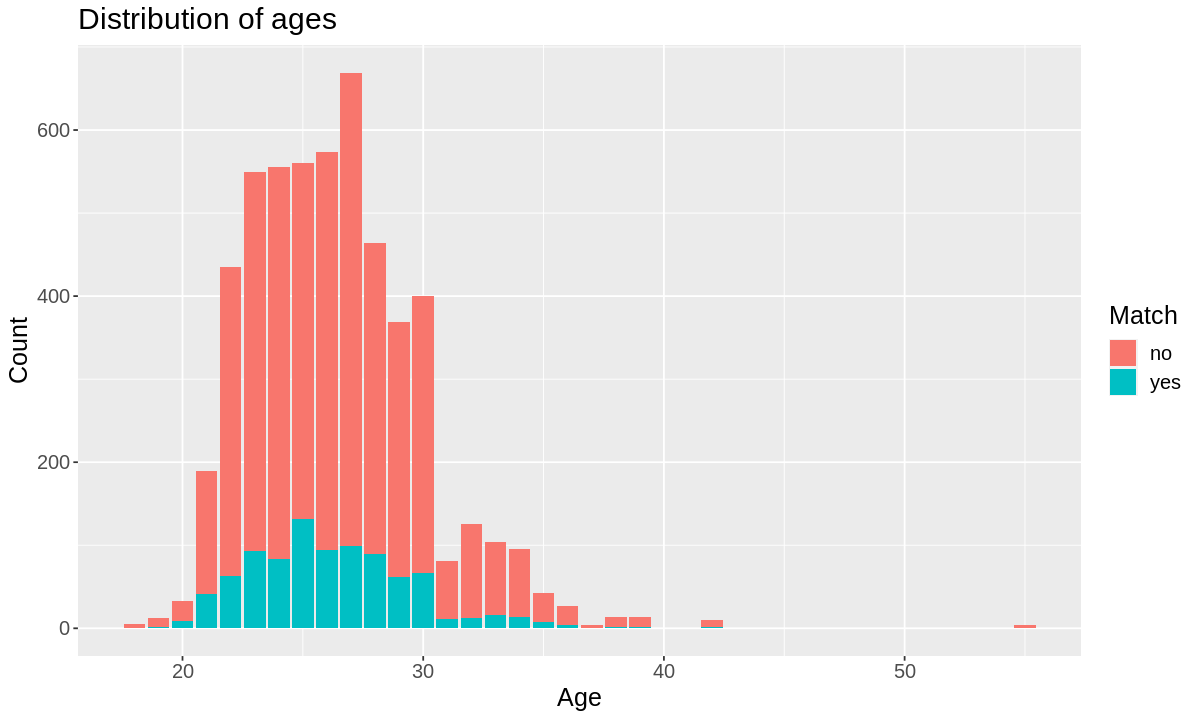

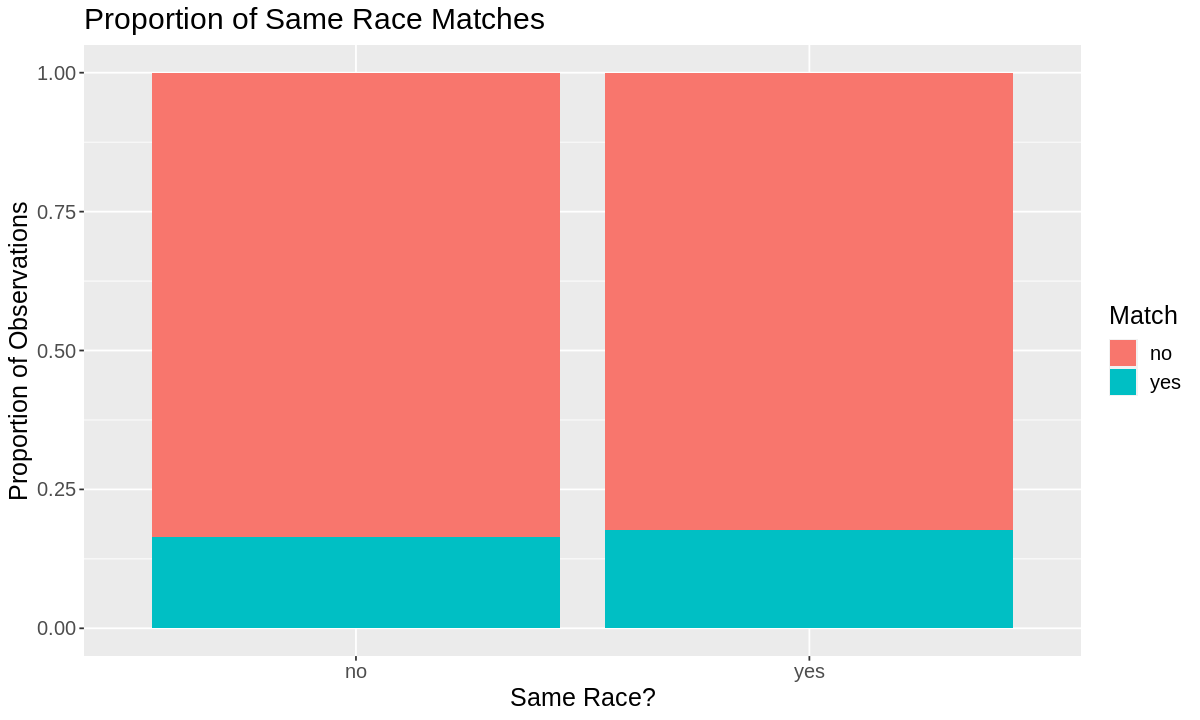

In [91]:
# Distribution of Ages
options(repr.plot.width=10, repr.plot.height=6)

age_plot <- speed_dating_train |>
    ggplot(aes(x = age, fill = match)) + 
    geom_bar() + 
    labs(x = "Age", y = "Count", fill = "Match") + 
    theme(text = element_text(size = 15)) + 
    ggtitle("Distribution of ages")
age_plot

same_race_comparison <- speed_dating_train |>
    group_by(match, same_race) |>
    summarize(count = n()) 
same_race_plot <- speed_dating_train |>
    ggplot(aes(x = same_race, fill = match)) + 
    geom_bar(position = "fill") + 
    labs(x = "Same Race?", y = "Proportion of Observations", fill = "Match") + 
    theme(text = element_text(size = 15)) + 
    ggtitle("Proportion of same race matches")
same_race_plot

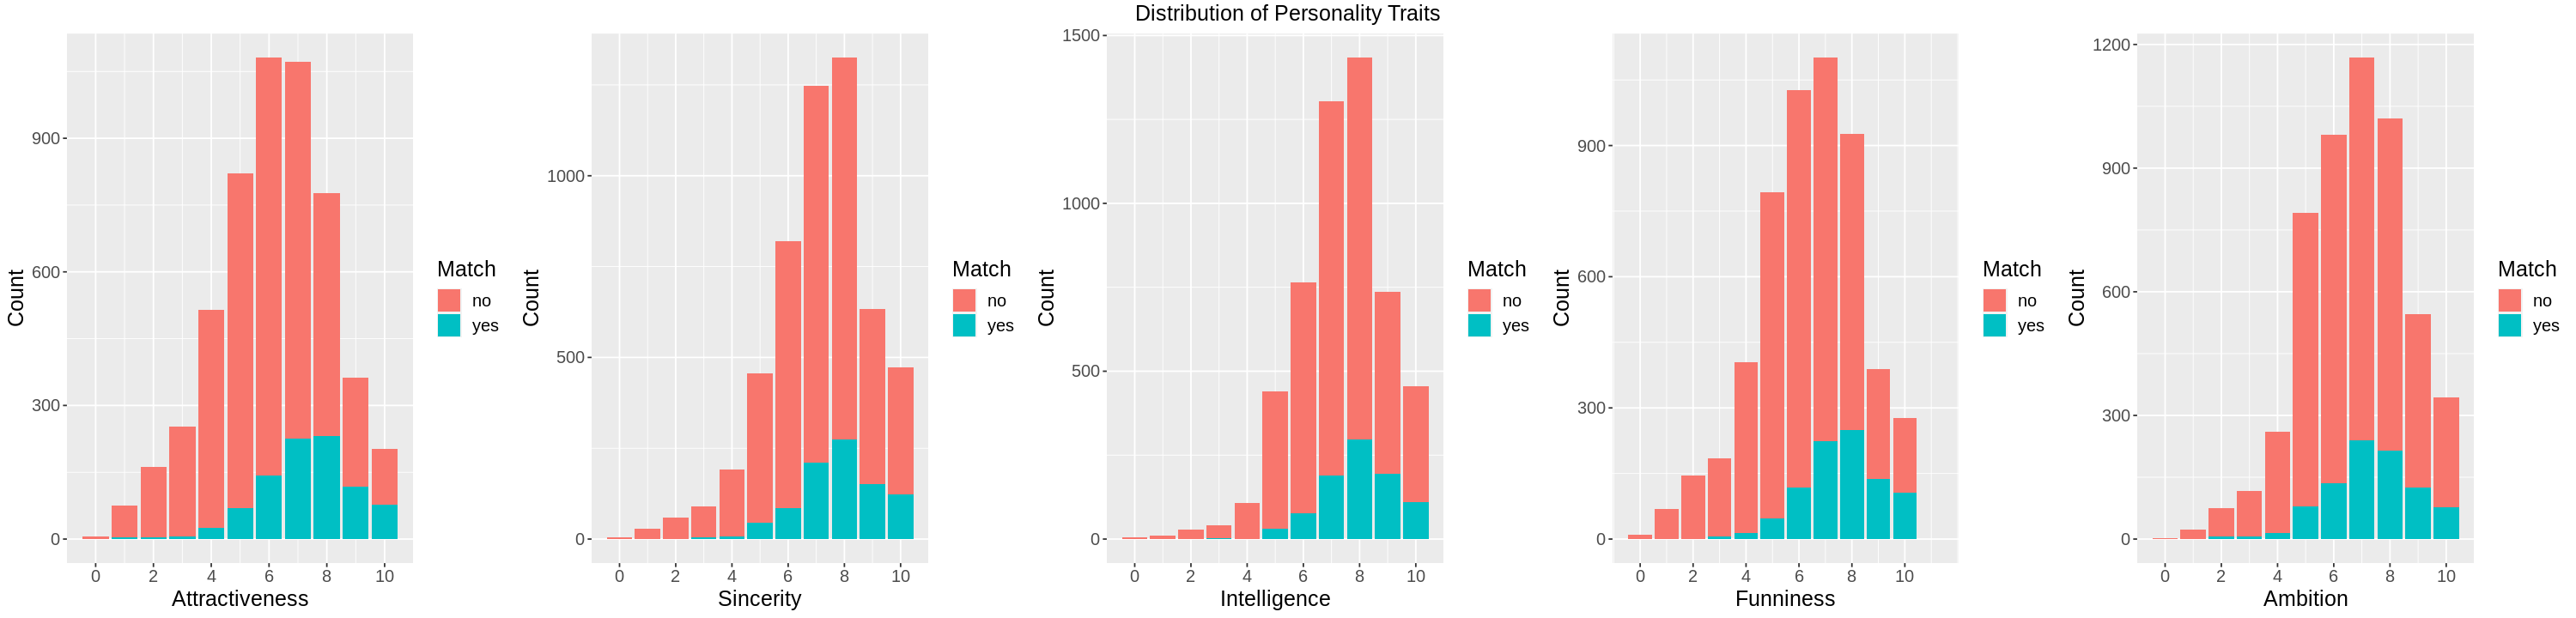

In [78]:
# Distribuitions of Personality Traits
options(repr.plot.width=25, repr.plot.height=6)

attractiveness_plot <- speed_dating_train |>
    ggplot(aes(x = attractiveness, fill = match)) + 
    geom_bar() + 
    labs(x = "Attractiveness", y = "Count", fill = "Match") + 
    scale_x_continuous(breaks = seq(0, 10, by = 2)) + 
    theme(text = element_text(size = 15))

sincerity_plot <- speed_dating_train |>
    ggplot(aes(x = sincerity, fill = match)) + 
    geom_bar() + 
    labs(x = "Sincerity", y = "Count", fill = "Match") + 
    scale_x_continuous(breaks = seq(0, 10, by = 2)) + 
    theme(text = element_text(size = 15))

intelligence_plot <- speed_dating_train |>
    ggplot(aes(x = intelligence, fill = match)) + 
    geom_bar() + 
    labs(x = "Intelligence", y = "Count", fill = "Match") + 
    scale_x_continuous(breaks = seq(0, 10, by = 2)) + 
    theme(text = element_text(size = 15))

funny_plot <- speed_dating_train |>
    ggplot(aes(x = funniness, fill = match)) + 
    geom_bar() + 
    labs(x = "Funniness", y = "Count", fill = "Match") + 
    scale_x_continuous(breaks = seq(0, 10, by = 2)) + 
    theme(text = element_text(size = 15))

ambition_plot <- speed_dating_train |>
    ggplot(aes(x = ambition, fill = match)) + 
    geom_bar() + 
    labs(x = "Ambition", y = "Count", fill = "Match") + 
    scale_x_continuous(breaks = seq(0, 10, by = 2)) + 
    theme(text = element_text(size = 15))


grid.arrange(attractiveness_plot, sincerity_plot, intelligence_plot, funny_plot, ambition_plot, 
             nrow = 1, top = textGrob("Distribution of Personality Traits", gp=gpar(fontsize=15,font=8)))

### Methods

In this project, we will use the classification method to predict whether a person will match or not based on their reported personality traits. We plan to implement the K-nearest neighbors (KNN) classification algorithm, by splitting our dataset into training and testing datasets. Then, we will use the cross-validation method to find the best K-value for the nearest neighbors algorithm. For the data analysis, we will be using the columns gender, age, date, attr_o, sinc_o, intel_o, fun_o, and amb_o to predict the probability of matched couples.

### Expected Outcomes and Significance

Upon executing our visual analysis, we expect to find which characteristics prominently lead to a match in speed dating. Looking at the variables individually, we postulate that attraction, sincerity, intelligence, funniness and ambition of an individual should result in a higher probability of a match. Additionally, we expect that individuals that are younger are more likely to have a match percentage along with women. We are predicting that out of the aforementioned factors, attraction, funniness and age will be the most accurate factors that aid in predicting the success of speed dating.

The impact of these findings are immensely helpful in the matrimonial industry. If dating services understand which factors influence a successful match, they would be able to implement the same in order to give their customers more accurate matches thus positively influencing people's lives. 

Some future questions this could lead to include:
- How do social psychological factors such as first impressions and social norms affect date selection?
- Is there a trend in what individual preferences result in a higher chance of a match?
- What are the patterns of conversation and interaction during speed dating?
- Can we predict which pairs of participants are likely to match based on their own preferences?
- How does the speed dating context influence date selection and relationship outcomes?


###### 